In [1]:
import pandas as pd 
import numpy as np
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

### Filtro colaborativo: Vectorizacion de matriz con sklearn

##### Debido a la forma de las bases de datos y mas importante los objetivos en mente del proyecto, este fue el tipo de modelos se decidio implementar, buscando recomendar a los usuarios que podria gustarles encontramos como mejor forma de hacerlo analizar las similitudes de un usuario particular con los demas y utilizar estos parecidos para inferir una recomendación

In [2]:
data = pd.read_csv("DataWarehouse/Google-CF.csv")

In [3]:
nombres_data = data[["user_id", "name_x"]]

Se utilizaran solo 3 columnas par aesta instancia, la etiqueta de usuario, de locacion y el rating que del usuario a esta ultima 

In [4]:
data = data[["user_id", "gmap_id", "rating"]]

In [5]:
data = data.head(17000)

Agregacion para analizar y si fuese necesario filtrar filas

In [8]:
agg_data = data.groupby('gmap_id').agg(
    mean_rating=('rating', 'mean'),
    numero_ratings=('rating', 'count')
).reset_index()

In [9]:
agg_data.sort_values(by="numero_ratings", ascending=True)

,gmap_id,mean_rating,numero_ratings
0,0x14589e44e1543481:0x488689a13c898c2d,4.0,1
11324,0x88c2f2a928337e2b:0xb7dc20ed929c4dec,3.0,1
11325,0x88c2f2dbe1dfdb2d:0x722c38ccd252a0bc,5.0,1
11326,0x88c2f2ef4a1e35e5:0x984360de81307c62,5.0,1
11327,0x88c2f2fddafb8031:0x31583dd6799caa6,5.0,1
...,...,...,...
5673,0x86d5cfd16111332b:0x5410628f63a9901d,4.0,1
5674,0x86d5d1ec6ca96397:0x99bdbd643199f63f,5.0,1
5675,0x86d5e048340ecd3b:0x7ccdbc4058625ebb,5.0,1
5661,0x8634be4f6924e6db:0xc8ab4805af061c64,5.0,1


In [10]:
agg_ratings_100 = agg_data[agg_data["numero_ratings"]>=1]

Vemos con este grafico que la calificacion mas preponderante es por mucho 5

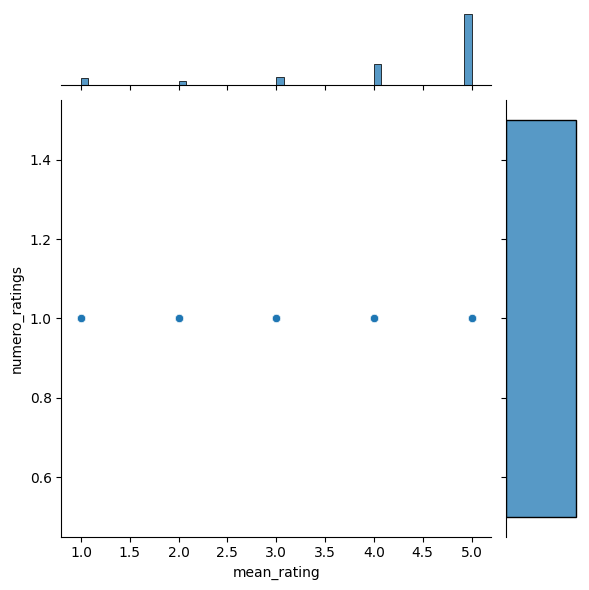

In [11]:
sns.jointplot(x='mean_rating', y='numero_ratings', data=agg_ratings_100)

##### Siendo que el modelo se basa en analizar una matriz para contraponer a un usuario con otro frente a su opinion de los establecimientos, la siguiente seccion crea una matriz con usuarios como filas y locaciones como columnas. con calificaciones como datos. 



In [13]:
matrix = data.pivot_table(index="user_id", columns="gmap_id", values="rating")


In [14]:
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis= 'rows')

##### Luego de que se normalizan los datos, se analiza las correlaciones entre los usuarios

In [15]:
parecido_usuarios = matrix.T.corr()

Analizando similitudes:

In [ ]:
similitud_coseno = cosine_similarity(matrix.fillna(0))

Eligiendo un usuario para testear:

In [ ]:

usuario_elegido = data["user_id"][10]

parecido_usuarios.drop(index=usuario_elegido, inplace=True)

In [ ]:
nombres_data[nombres_data["user_id"]==usuario_elegido]["name_x"].values[0]

'daniel lewis'

In [ ]:
n = 10

parecido_usuarios_min = 0.1

similares = parecido_usuarios[parecido_usuarios[usuario_elegido]>parecido_usuarios_min][usuario_elegido].sort_values(ascending=False)[:n]

print(f"Los usuarios similares para {nombres_data[nombres_data["user_id"]==usuario_elegido]["name_x"].values[0]} son: {similares}")

Los usuarios similares para daniel lewis son: Series([], Name: 1.0205733682409972e+20, dtype: float64)


C:\Users\ignac\AppData\Local\Temp\ipykernel_7960\3115067996.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  similares = parecido_usuarios[parecido_usuarios[usuario_elegido]>parecido_usuarios_min][usuario_elegido].sort_values(ascending=False)[:n]


In [ ]:
similares

Series([], Name: 1.0205733682409972e+20, dtype: float64)

Eliminando restaurantes que el usuario buscado ya conoce

In [ ]:
vistas_user =  matrix[matrix.index == usuario_elegido].dropna(axis=1, how='all')

SyntaxError: invalid syntax (2135246783.py, line 1)

Dejando locaciones que hayan recomendado usuarios similares

In [ ]:
similares_vieron = matrix[matrix.index.isin(parecido_usuarios.index)].dropna(axis=1, how='all')

In [ ]:
similares_vieron.drop(vistas_user.columns,axis=1, inplace=True, errors='ignore')


Para recomendarle M locales a un usuario:

In [ ]:
items_recomendado = {}


for i in similares_vieron.columns:
  
  rating = similares_vieron[i]
  
  total = 0
  
  count = 0
  
  for u in parecido_usuarios.index:
    if pd.isna(rating[u]) == False:
      
      score = parecido_usuarios[u] * rating[u]
      
      total += score
      
      count +=1
  
  items_recomendado[i] = total / count


item_score = pd.DataFrame(items_recomendado.items(), columns=['locacion', 'rating'])

ranked_item_score = items_recomendado.sort_values(by='movie_score', ascending=False)


m = 10
ranked_item_score.head(m)